In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [2]:
heart_failure = pd.read_csv("../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")
heart_failure.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


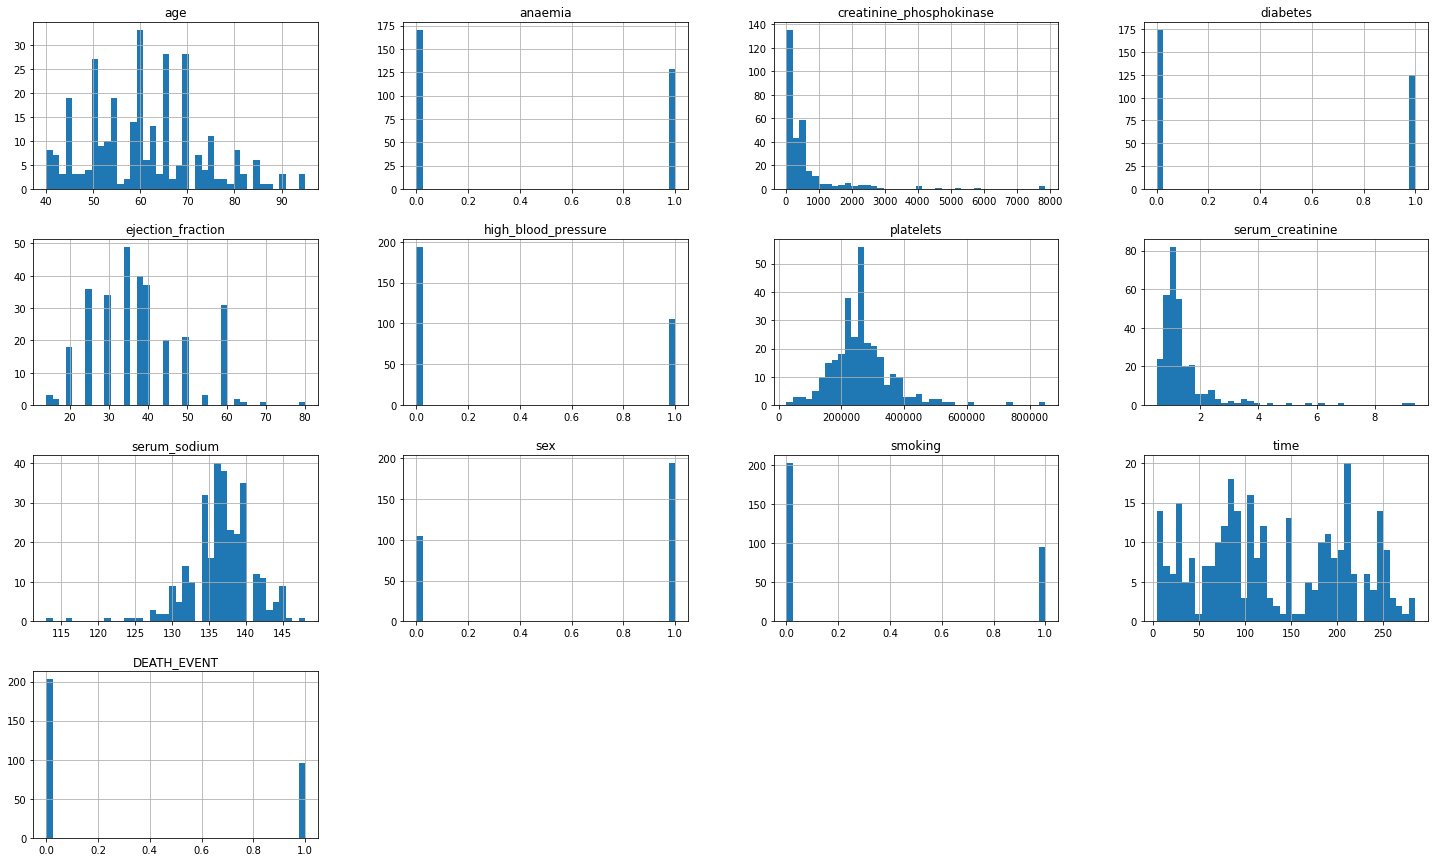

In [3]:
import matplotlib.pyplot as plt

heart_failure.hist(bins=40,figsize=(25,15))
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

train_set,test_set = train_test_split(heart_failure,test_size=0.2,random_state=42)
heart = train_set.copy()

In [5]:
heart_data = heart.drop('DEATH_EVENT',axis=1)
heart_data_labels = heart['DEATH_EVENT'].copy()

In [6]:
shuffle_index = np.random.permutation(len(heart_data))
heart_data,heart_data_labels = heart_data.iloc[shuffle_index],heart_data_labels.iloc[shuffle_index]

In [7]:
from sklearn.preprocessing import StandardScaler
#Scaling the data - Feature scaling
std_scaler = StandardScaler()
heart_data_scaled = std_scaler.fit_transform(heart_data)

# SGDClassifier

In [8]:
from sklearn.linear_model import SGDClassifier,LogisticRegression

sgd_clf = SGDClassifier()
sgd_clf.fit(heart_data_scaled,heart_data_labels)

SGDClassifier()

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_curve,roc_auc_score

heart_pred = cross_val_predict(sgd_clf,heart_data_scaled,heart_data_labels,cv=3)
print(confusion_matrix(heart_data_labels,heart_pred))
print(precision_score(heart_data_labels,heart_pred))
print(recall_score(heart_data_labels,heart_pred))

[[138  30]
 [ 22  49]]
0.620253164556962
0.6901408450704225


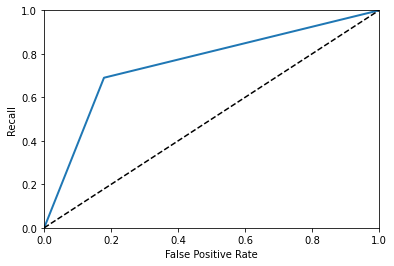

In [10]:
fpr,tpr,threshold = roc_curve(heart_data_labels,heart_pred)

def plot_ROC_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')

plot_ROC_curve(fpr,tpr)
plt.show()

In [11]:
roc_auc_score(heart_data_labels,heart_pred)

0.755784708249497

# LogisticRegressor

In [12]:
log_reg = LogisticRegression()
log_reg.fit(heart_data,heart_data_labels)

LogisticRegression()

In [13]:
heart_pred_log = cross_val_predict(log_reg,heart_data_scaled,heart_data_labels,cv=3)
print(confusion_matrix(heart_data_labels,heart_pred))
print(precision_score(heart_data_labels,heart_pred))
print(recall_score(heart_data_labels,heart_pred))

[[138  30]
 [ 22  49]]
0.620253164556962
0.6901408450704225


In [14]:
roc_auc_score(heart_data_labels,heart_pred_log)

0.7744382964453386

# RandomForest

In [15]:
from sklearn.ensemble import RandomForestClassifier

forest_clas = RandomForestClassifier()
forest_clas.fit(heart_data_scaled,heart_data_labels)

RandomForestClassifier()

In [16]:
heart_pred_forest = cross_val_predict(forest_clas,heart_data_scaled,heart_data_labels,cv=3)
print(confusion_matrix(heart_data_labels,heart_pred_forest))
print(precision_score(heart_data_labels,heart_pred_forest))
print(recall_score(heart_data_labels,heart_pred_forest))

[[156  12]
 [ 15  56]]
0.8235294117647058
0.7887323943661971


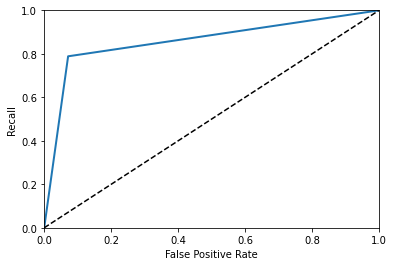

In [17]:
fpr1,tpr1,threshold1 = roc_curve(heart_data_labels,heart_pred_forest)

plot_ROC_curve(fpr1,tpr1)
plt.show()

In [18]:
roc_auc_score(heart_data_labels,heart_pred_forest)

0.8586519114688128

# KNeighbors

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(heart_data,heart_data_labels)

KNeighborsClassifier()

In [20]:
heart_pred_knn = cross_val_predict(knn_clf,heart_data_scaled,heart_data_labels,cv=3)
print(confusion_matrix(heart_data_labels,heart_pred_knn))
print(precision_score(heart_data_labels,heart_pred_knn))
print(recall_score(heart_data_labels,heart_pred_knn))

[[158  10]
 [ 47  24]]
0.7058823529411765
0.3380281690140845


In [21]:
roc_auc_score(heart_data_labels,heart_pred_knn)

0.6392521797451375

RandomForestClassifier is much better than Logistic regression. However it is overfitting the training set. We try attempting fine tuning the model.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = [{'n_estimators':[10,100,500,1000],'max_depth':[3,5,8,10,15],'max_features':['log2','auto','sqrt']}]
auc_scorer = make_scorer(roc_auc_score)
grid_search = GridSearchCV(forest_clas,parameters,scoring=auc_scorer)
grid_search = grid_search.fit(heart_data_scaled,heart_data_labels)
forest_clas = grid_search.best_estimator_
heart_predictions = cross_val_predict(forest_clas,heart_data,heart_data_labels,cv=3)
forest_score = roc_auc_score(heart_data_labels,heart_predictions)
print(forest_score)

0.8334590878604963


In [23]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score,params)

0.7876317799847211 {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 10}
0.8281538069773363 {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 100}
0.8260300483829897 {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 500}
0.8362032085561498 {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 1000}
0.8051667939903234 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 10}
0.8197504456327985 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 100}
0.8362032085561498 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 500}
0.829536541889483 {'max_depth': 3, 'max_features': 'auto', 'n_estimators': 1000}
0.7904048892284186 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 10}
0.8290603514132927 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100}
0.829536541889483 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500}
0.8230888719124014 {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1000}
0.7998905016552076 {'max_depth

Now we try the fine tuned model with the test data and see how it performs

In [24]:
from sklearn.metrics import accuracy_score

final_model = grid_search.best_estimator_

X_test = test_set.drop('DEATH_EVENT',axis=1)
y_test = test_set['DEATH_EVENT']
X_test_scaled = std_scaler.fit_transform(X_test)

final_predictions = final_model.predict(X_test_scaled)
roc_auc_score(y_test,final_predictions)

0.7314285714285714

In [25]:
grid_search.best_params_

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}